**TRAFFIC FLOW PREDICTION USING GRAPN NEURAL NETWORKS**

**Data Preprocessing**

In [1]:
import os
import numpy as np

#Shape of the original data is in the form:
 (sequence_length, num_of_vertices, num_of_features) (16992, 307, 3)
 # Number of detectors:307 
 (detect speed,congestion etc of car)
 in time gap of 5 minutes each.
 so for one hour shape oof the data will be (12,307,3)
 such that in 1 hour we have 12 time steps of 5 minutes each
 # We can predict data by using three different ways:
 1)The recent segment
 2)Daily periodic segment
 3)Weekly periodic segment
 #Here, We are going to use recent periodic segment

For example, the first 12 points(0:12) will be extracted from original data have 16992 points i.e. original[0:12]. Our target is the next hour so it will be the next 12 points(12:24) i.g. original[12:24]

Generating more and moving 5 minutes in the future,

The first 12 points(1:13) will be extracted from original data have 16992 points i.e. original[1:13] The target is the next hour so it will be the next 12 points(13:25) i.g. original[13:25]

And so on.

How many INPUT data and TARGET examples do we have now ? We have 16969 examples which is 16992 (original) - 23

The missing 23 points are the first 11 points(first hour) in the original sequence and the last 12 points(last hour) in the sequence i.e. the first hour data can't be predicted from any other previous data and the last hour data can't be used for predicting any future data because it's the last one in the training. So we ignore both.
#spliting of dataset
1)Train:35 days (10181 datapoints)
2)Validation: 12 days (3394 datapoints)
3)Testing :12 days (3394 datapoints)

In [2]:
##loading the data (PEMS04)
graph_signal_matrix_filename = '/content/drive/MyDrive/traffic pred.by gnn/final data/PEMS04.npz'
data = np.load(graph_signal_matrix_filename)
data['data'].shape

(16992, 307, 3)

In [4]:
def search_data(sequence_length, num_of_depend, label_start_idx,num_for_predict, units, points_per_hour):
    
    #sequence_length: int, length of all history data
    #num_of_depend: int,
    #label_start_idx: int, the first index of predicting target
    #num_for_predict: int, the number of points will be predicted for each sample
    #units: int, week: 7 * 24, day: 24, recent(hour): 1
    #points_per_hour: int, number of points per hour, depends on data
    
    

    if points_per_hour < 0:
        raise ValueError("points_per_hour should be greater than 0!")

    if label_start_idx + num_for_predict > sequence_length:
        return None

    x_idx = []
    for i in range(1, num_of_depend + 1):
        start_idx = label_start_idx - points_per_hour * units * i
        end_idx = start_idx + num_for_predict
        if start_idx >= 0:
            x_idx.append((start_idx, end_idx))
        else:
            return None

    if len(x_idx) != num_of_depend:
        return None

    return x_idx[::-1]

In [28]:
def get_sample_indices(data_sequence, num_of_weeks, num_of_days, num_of_hours, label_start_idx, num_for_predict, points_per_hour=12):
    
    #data_sequence: np.ndarray shape is (sequence_length, num_of_vertices, num_of_features)
    #num_of_weeks, num_of_days, num_of_hours: int
    #label_start_idx: int, the first index of predicting target
    #num_for_predict: int,the number of points will be predicted for each sample
    #points_per_hour: int, default 12, number of points per hour
    
    #week_sample: np.ndarray shape is (num_of_weeks * points_per_hour, num_of_vertices, num_of_features)
    #day_sample: np.ndarray shape is (num_of_days * points_per_hour,  num_of_vertices, num_of_features)
    #hour_sample: np.ndarray   shape is (num_of_hours * points_per_hour, num_of_vertices, num_of_features)
    #target: np.ndarray shape is (num_for_predict, num_of_vertices, num_of_features)
    
    #week_sample, day_sample, hour_sample = None, None, None

    if label_start_idx + num_for_predict > data_sequence.shape[0]: 
        return week_sample, day_sample, hour_sample, None

    if num_of_weeks > 0:
        week_indices = search_data(data_sequence.shape[0], num_of_weeks, label_start_idx, num_for_predict,7 * 24, points_per_hour)
        if not week_indices:
            return None, None, None, None

        week_sample = np.concatenate([data_sequence[i: j] for i, j in week_indices], axis=0)

    if num_of_days > 0:
        day_indices = search_data(data_sequence.shape[0], num_of_days,  label_start_idx, num_for_predict, 24, points_per_hour)
        if not day_indices:
            return None, None, None, None

        day_sample = np.concatenate([data_sequence[i: j] for i, j in day_indices], axis=0)
        
    if num_of_hours > 0:
        hour_indices = search_data(data_sequence.shape[0], num_of_hours, label_start_idx, num_for_predict, 1, points_per_hour)
        if not hour_indices:
            return None, None, None, None
        hour_sample = np.concatenate([data_sequence[i: j] for i, j in hour_indices], axis=0)
    
    if num_of_hours > 10:
        return 1;
    target = data_sequence[label_start_idx: label_start_idx + num_for_predict]

    return week_sample, day_sample, hour_sample, target

In [8]:
##assigning the values to corresponding parameters

num_of_vertices = 307
points_per_hour = 12
num_for_predict = 12
num_of_weeks = 0
num_of_days = 0
num_of_hours = 1

training_set, validation_set, testing_set = read_and_generate_dataset(graph_signal_matrix_filename, 0, 0, num_of_hours, 
                                                                      num_for_predict, points_per_hour=points_per_hour)

In [29]:
def read_and_generate_dataset(graph_signal_matrix_filename, num_of_weeks, num_of_days, num_of_hours, num_for_predict, points_per_hour=12):
    
    #Read original data 
    data_seq = np.load(graph_signal_matrix_filename)['data']  # (sequence_length, num_of_vertices, num_of_features) (16992, 307, 3)
    
    
    all_samples = []
    for idx in range(data_seq.shape[0]):
        sample = get_sample_indices(data_seq, num_of_weeks, num_of_days, num_of_hours, idx, num_for_predict, points_per_hour)
        if ((sample[0] is None) and (sample[1] is None) and (sample[2] is None)):
            continue

        week_sample, day_sample, hour_sample, target = sample #  week_sample, day_sample are None because we are predicting per hour
        #print(target.shape) # hour_sample and target (12, 307, 3)
        sample = []  # [(week_sample),(day_sample),(hour_sample),target,time_sample]

        if num_of_weeks > 0:
            week_sample = np.expand_dims(week_sample, axis=0).transpose((0, 2, 3, 1))  # (1,N,F,T)
            sample.append(week_sample)

        if num_of_days > 0:
            day_sample = np.expand_dims(day_sample, axis=0).transpose((0, 2, 3, 1))  # (1,N,F,T)
            sample.append(day_sample)

        if num_of_hours > 0:
            hour_sample = np.expand_dims(hour_sample, axis=0).transpose((0, 2, 3, 1))  # (1,N,F,T)
            sample.append(hour_sample)

        target = np.expand_dims(target, axis=0).transpose((0, 2, 3, 1))[:, :, 0, :]  # (1,N,T)
        sample.append(target)
        time_sample = np.expand_dims(np.array([idx]), axis=0)  # (1,1)
        sample.append(time_sample)
        all_samples.append(sample)#sampe：[(week_sample),(day_sample),(hour_sample),target,time_sample] = [(1,N,F,Tw),(1,N,F,Td),(1,N,F,Th),(1,N,Tpre),(1,1)]

    split_line1 = int(len(all_samples) * 0.6)
    split_line2 = int(len(all_samples) * 0.8)

    training_set = [np.concatenate(i, axis=0)  for i in zip(*all_samples[:split_line1])] #[(B,N,F,Tw),(B,N,F,Td),(B,N,F,Th),(B,N,Tpre),(B,1)]
    validation_set = [np.concatenate(i, axis=0) for i in zip(*all_samples[split_line1: split_line2])]
    testing_set = [np.concatenate(i, axis=0) for i in zip(*all_samples[split_line2:])]

    return training_set, validation_set, testing_set

In [30]:
##normalizing our data by using z sore method
def normalization(train, val, test):
    

    assert train.shape[1:] == val.shape[1:] and val.shape[1:] == test.shape[1:]  # ensure the num of nodes is the same
    mean = train.mean(axis=(0,1,3), keepdims=True)
    std = train.std(axis=(0,1,3), keepdims=True)
    print('mean.shape:',mean.shape)
    print('std.shape:',std.shape)

    def normalize(x):
        return (x - mean) / std

    train_norm = normalize(train)
    val_norm = normalize(val)
    test_norm = normalize(test)

    return {'_mean': mean, '_std': std}, train_norm, val_norm, test_norm

In [11]:
##preparing train,test and validation datasets to feed our model
train_x = np.concatenate(training_set[:-2], axis=-1)  # (B,N,F,T') #Join a sequence of arrays along an existing axi
val_x = np.concatenate(validation_set[:-2], axis=-1)
test_x = np.concatenate(testing_set[:-2], axis=-1)

train_target = training_set[-2]  # (B,N,T)
val_target = validation_set[-2]
test_target = testing_set[-2]

train_timestamp = training_set[-1]  # (B,1)
val_timestamp = validation_set[-1]
test_timestamp = testing_set[-1]

(stats, train_x_norm, val_x_norm, test_x_norm) = normalization(train_x, val_x, test_x)

all_data = {'train': { 'x': train_x_norm, 'target': train_target,'timestamp': train_timestamp},
            'val': {'x': val_x_norm, 'target': val_target, 'timestamp': val_timestamp},
            'test': {'x': test_x_norm, 'target': test_target, 'timestamp': test_timestamp},
            'stats': {'_mean': stats['_mean'], '_std': stats['_std']} }

mean.shape: (1, 1, 3, 1)
std.shape: (1, 1, 3, 1)


In [12]:

print('train x:', all_data['train']['x'].shape)
print('train target:', all_data['train']['target'].shape)
print('train timestamp:', all_data['train']['timestamp'].shape)
print()
print('val x:', all_data['val']['x'].shape)
print('val target:', all_data['val']['target'].shape)
print('val timestamp:', all_data['val']['timestamp'].shape)
print()
print('test x:', all_data['test']['x'].shape)
print('test target:', all_data['test']['target'].shape)
print('test timestamp:', all_data['test']['timestamp'].shape)
print()
print('train data _mean :', all_data['stats']['_mean'].shape, all_data['stats']['_mean'])
print('train data _std :', all_data['stats']['_std'].shape, all_data['stats']['_std'])

train x: (10181, 307, 3, 12)
train target: (10181, 307, 12)
train timestamp: (10181, 1)

val x: (3394, 307, 3, 12)
val target: (3394, 307, 12)
val timestamp: (3394, 1)

test x: (3394, 307, 3, 12)
test target: (3394, 307, 12)
test timestamp: (3394, 1)

train data _mean : (1, 1, 3, 1) [[[[2.07227338e+02]
   [5.13195612e-02]
   [6.34740574e+01]]]]
train data _std : (1, 1, 3, 1) [[[[1.56477655e+02]
   [4.78541626e-02]
   [8.10351724e+00]]]]


In [13]:
file = os.path.basename(graph_signal_matrix_filename).split('.')[0]
dirpath = '.'
filename = os.path.join(dirpath, file + '_r' + str(num_of_hours) + '_d' + str(num_of_days) + '_w' + str(num_of_weeks)) + '_astcgn'
print('save file:', filename)
np.savez_compressed(filename,
                train_x=all_data['train']['x'],train_target=all_data['train']['target'],train_timestamp=all_data['train']['timestamp'],
                val_x=all_data['val']['x'], val_target=all_data['val']['target'],val_timestamp=all_data['val']['timestamp'],
                test_x=all_data['test']['x'], test_target=all_data['test']['target'], test_timestamp=all_data['test']['timestamp'],
                mean=all_data['stats']['_mean'], std=all_data['stats']['_std'])

save file: ./PEMS04_r1_d0_w0_astcgn


In [18]:
#importing required liabraries 
import os
from time import time
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx #Create an empty graph with no nodes and no edges.import networkx as nx
                      #EG:G = nx.Graph()



import torch ##importing pytorch
import torch.nn as nn #convolution functions in torch
import torch.optim as optim##s a package implementing various optimization algorithms
import torch.nn.functional as F #convolution functions in torch
from scipy.sparse.linalg import eigs## to Find k eigenvalues and eigenvectors of the square matrix A.


USE_CUDA = torch.cuda.is_available() ##checking avilability of cuda on our device
DEVICE = torch.device('cuda:0')
print("CUDA:", USE_CUDA, DEVICE)

from tensorboardX import SummaryWriter #serve visualizations of the training progress of a neural network, it visualizes scalar values, images, text,
sw = SummaryWriter(logdir='.', flush_secs=5)

import math
from typing import Optional, List, Union

 

from torch_geometric.data import Data ##describing homogeneous graph(only one type of edges and nodes)
from torch_geometric.typing import OptTensor # used to optimize tensors
from torch_geometric.nn.conv import MessagePassing ## used to mesagepassing by using adjency matrix between nodes 
from torch_geometric.transforms import LaplacianLambdaMax #Computes the highest eigenvalue of the graph Laplacian given by(laplacian: a matrix representation of a graph)
from torch_geometric.utils import remove_self_loops, add_self_loops, get_laplacian
from torch_geometric.utils import to_dense_adj
from torch_scatter import scatter_add

CUDA: True cuda:0


**End of Data Processing :)**

Cool...now we have well processed and prepared Data ,that is no we can feed this data to our Model . 

In [19]:
!pip install torch_geometric

In [20]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.11.0+cu113.html

Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html


In [21]:
!pip install tensorboardX

**to_dense_adj**:

Converts batched sparse adjacency matrices given by edge indices and edge attributes to a single dense batched adjacency matrix.
reference link:https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/utils/to_dense_adj.html
**scatter add**:
https://pytorch-scatter.readthedocs.io/en/1.3.0/functions/add.html


In [22]:
##Loading preprocessed data 
def load_graphdata_channel1(graph_signal_matrix_filename, num_of_hours, num_of_days, num_of_weeks, batch_size,
                            shuffle=True, DEVICE = torch.device('cuda:0')):
    
    #three DataLoaders, each dataloader contains:
    #test_x_tensor: (B, N_nodes, in_feature, T_input)
    #test_decoder_input_tensor: (B, N_nodes, T_output)
    #test_target_tensor: (B, N_nodes, T_output)
    

    file = os.path.basename(graph_signal_matrix_filename).split('.')[0]
    filename = os.path.join('/content/drive/MyDrive/traffic pred.by gnn/final data', file + '_r' + str(num_of_hours) + '_d' + str(num_of_days) + '_w' + str(num_of_weeks)) +'_astcgn'
    print('load file:', filename)

    file_data = np.load(filename + '.npz')
    train_x = file_data['train_x']  # (10181, 307, 3, 12)
    train_x = train_x[:, :, 0:1, :]
    train_target = file_data['train_target']  # (10181, 307, 12)

    val_x = file_data['val_x']
    val_x = val_x[:, :, 0:1, :]
    val_target = file_data['val_target']

    test_x = file_data['test_x']
    test_x = test_x[:, :, 0:1, :]
    test_target = file_data['test_target']

    mean = file_data['mean'][:, :, 0:1, :]  # (1, 1, 3, 1)
    std = file_data['std'][:, :, 0:1, :]  # (1, 1, 3, 1)

    # train_loader 
    train_x_tensor = torch.from_numpy(train_x).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
    train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
    train_dataset = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)

    #val_loader 
    val_x_tensor = torch.from_numpy(val_x).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
    val_target_tensor = torch.from_numpy(val_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
    val_dataset = torch.utils.data.TensorDataset(val_x_tensor, val_target_tensor)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    #  test_loader 
    test_x_tensor = torch.from_numpy(test_x).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
    test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
    test_dataset = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # print
    print('train:', train_x_tensor.size(), train_target_tensor.size())
    print('val:', val_x_tensor.size(), val_target_tensor.size())
    print('test:', test_x_tensor.size(), test_target_tensor.size())

    return train_loader, train_target_tensor, val_loader, val_target_tensor, test_loader, test_target_tensor, mean, std

In [23]:
##assigning values to our parameters
graph_signal_matrix_filename = '/content/drive/MyDrive/traffic pred.by gnn/final data/PEMS04.npz'
batch_size = 32
num_of_weeks = 0
num_of_days = 0
num_of_hours = 1

train_loader, train_target_tensor, val_loader, val_target_tensor, test_loader, test_target_tensor, _mean, _std = load_graphdata_channel1(
    graph_signal_matrix_filename, num_of_hours, num_of_days, num_of_weeks, batch_size)

load file: /content/drive/MyDrive/traffic pred.by gnn/final data/PEMS04_r1_d0_w0_astcgn
train: torch.Size([10181, 307, 1, 12]) torch.Size([10181, 307, 12])
val: torch.Size([3394, 307, 1, 12]) torch.Size([3394, 307, 12])
test: torch.Size([3394, 307, 1, 12]) torch.Size([3394, 307, 12])


**Loading the graph by using adjency matrix of our data ** 

In [24]:
#adjacency matrix
def get_adjacency_matrix(distance_df_filename, num_of_vertices, id_filename=None):
    
    if 'npy' in distance_df_filename:  # false
        adj_mx = np.load(distance_df_filename)
        return adj_mx, None
    else:
        
        
        import csv
        A = np.zeros((int(num_of_vertices), int(num_of_vertices)),dtype=np.float32)
        distaneA = np.zeros((int(num_of_vertices), int(num_of_vertices)), dtype=np.float32)

        
        if id_filename: # false
            with open(id_filename, 'r') as f:
                id_dict = {int(i): idx for idx, i in enumerate(f.read().strip().split('\n'))} 

            with open(distance_df_filename, 'r') as f:
                f.readline()
                reader = csv.reader(f)
                for row in reader:
                    if len(row) != 3:
                        continue
                    i, j, distance = int(row[0]), int(row[1]), float(row[2])
                    A[id_dict[i], id_dict[j]] = 1
                    distaneA[id_dict[i], id_dict[j]] = distance
            return A, distaneA

        else:
         
            with open(distance_df_filename, 'r') as f:
                f.readline()
                reader = csv.reader(f)
                for row in reader:
                    if len(row) != 3:
                        continue
                    i, j, distance = int(row[0]), int(row[1]), float(row[2])
                    A[i, j] = 1
                    distaneA[i, j] = distance
            return A, distaneA

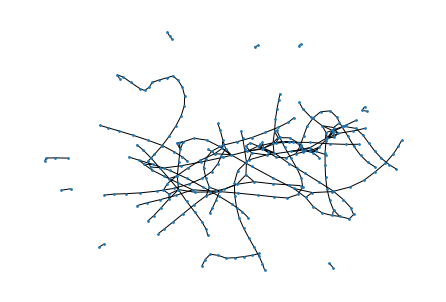

In [25]:
##ploting graph 
id_filename = None
adj_filename = '/content/drive/MyDrive/traffic pred.by gnn/final data/PEMS04.csv'
num_of_vertices = 307
adj_mx, distance_mx = get_adjacency_matrix(adj_filename, num_of_vertices, id_filename) #  adj_mx and distance_mx (307, 307)

rows, cols = np.where(adj_mx == 1)
edges = zip(rows.tolist(), cols.tolist())
gr = nx.Graph()
gr.add_edges_from(edges)
nx.draw(gr, node_size=3)
plt.show()
rows, cols = np.where(adj_mx == 1)
edges = zip(rows.tolist(), cols.tolist())
edge_index_data = torch.LongTensor(np.array([rows, cols])).to(DEVICE)

for more information of model architecture : 
https://pytorch-geometric-temporal.readthedocs.io/en/latest/_modules/torch_geometric_temporal/nn/attention/astgcn.html

In [32]:
#importing our model
from torch_geometric_temporal.nn.attention import ASTGCN   

nb_block = 2
in_channels = 1
K = 3
nb_chev_filter = 64
nb_time_filter = 64
time_strides = num_of_hours
num_for_predict = 12
len_input = 12
#L_tilde = scaled_Laplacian(adj_mx)
#cheb_polynomials = [torch.from_numpy(i).type(torch.FloatTensor).to(DEVICE) for i in cheb_polynomial(L_tilde, K)]
net = ASTGCN( nb_block, in_channels, K, nb_chev_filter, nb_time_filter, time_strides, num_for_predict, len_input, num_of_vertices).to(DEVICE)

print(net)

ASTGCN(
  (_blocklist): ModuleList(
    (0): ASTGCNBlock(
      (_temporal_attention): TemporalAttention()
      (_spatial_attention): SpatialAttention()
      (_chebconv_attention): ChebConvAttention(1, 64, K=3, normalization=None)
      (_time_convolution): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
      (_residual_convolution): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
      (_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (1): ASTGCNBlock(
      (_temporal_attention): TemporalAttention()
      (_spatial_attention): SpatialAttention()
      (_chebconv_attention): ChebConvAttention(64, 64, K=3, normalization=None)
      (_time_convolution): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
      (_residual_convolution): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (_final_conv): Conv2d(12, 12, kernel_size=(1, 64), strid

In [31]:
!pip install torch_geometric_temporal

  Using cached torch_geometric_temporal-0.52.0-py3-none-any.whl


In [33]:
learning_rate = 0.001
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

print('Net\'s state_dict:')
total_param = 0
for param_tensor in net.state_dict():
    print(param_tensor, '\t', net.state_dict()[param_tensor].size(), '\t', net.state_dict()[param_tensor].device)
    total_param += np.prod(net.state_dict()[param_tensor].size())
print('Net\'s total params:', total_param)
#--------------------------------------------------
print('Optimizer\'s state_dict:')
for var_name in optimizer.state_dict():
    print(var_name, '\t', optimizer.state_dict()[var_name])

Net's state_dict:
_blocklist.0._temporal_attention._U1 	 torch.Size([307]) 	 cuda:0
_blocklist.0._temporal_attention._U2 	 torch.Size([1, 307]) 	 cuda:0
_blocklist.0._temporal_attention._U3 	 torch.Size([1]) 	 cuda:0
_blocklist.0._temporal_attention._be 	 torch.Size([1, 12, 12]) 	 cuda:0
_blocklist.0._temporal_attention._Ve 	 torch.Size([12, 12]) 	 cuda:0
_blocklist.0._spatial_attention._W1 	 torch.Size([12]) 	 cuda:0
_blocklist.0._spatial_attention._W2 	 torch.Size([1, 12]) 	 cuda:0
_blocklist.0._spatial_attention._W3 	 torch.Size([1]) 	 cuda:0
_blocklist.0._spatial_attention._bs 	 torch.Size([1, 307, 307]) 	 cuda:0
_blocklist.0._spatial_attention._Vs 	 torch.Size([307, 307]) 	 cuda:0
_blocklist.0._chebconv_attention._weight 	 torch.Size([3, 1, 64]) 	 cuda:0
_blocklist.0._chebconv_attention._bias 	 torch.Size([64]) 	 cuda:0
_blocklist.0._time_convolution.weight 	 torch.Size([64, 64, 1, 3]) 	 cuda:0
_blocklist.0._time_convolution.bias 	 torch.Size([64]) 	 cuda:0
_blocklist.0._residual_

Defining the loss function

In [34]:
def masked_mae(preds, labels, null_val=np.nan):
    if np.isnan(null_val):
        mask = ~torch.isnan(labels)
    else:
        mask = (labels != null_val)
    mask = mask.float()
    mask /= torch.mean((mask))
    mask = torch.where(torch.isnan(mask), torch.zeros_like(mask), mask)
    loss = torch.abs(preds - labels)
    loss = loss * mask
    loss = torch.where(torch.isnan(loss), torch.zeros_like(loss), loss)
    return torch.mean(loss)

In [35]:
masked_flag=0
criterion = nn.L1Loss().to(DEVICE)
criterion_masked = masked_mae
loss_function = 'mse'

metric_method = 'unmask'
missing_value=0.0


if loss_function=='masked_mse':
    criterion_masked = masked_mse         #nn.MSELoss().to(DEVICE)
    masked_flag=1
elif loss_function=='masked_mae':
    criterion_masked = masked_mae
    masked_flag = 1
elif loss_function == 'mae':
    criterion = nn.L1Loss().to(DEVICE)
    masked_flag = 0
elif loss_function == 'rmse':
    criterion = nn.MSELoss().to(DEVICE)
    masked_flag= 0

for more info og mstgcn: https://github.com/ziyujia/MSTGCN/


In [36]:
def compute_val_loss_mstgcn(net, val_loader, criterion,  masked_flag,missing_value,sw, epoch, edge_index_data, limit=None):
    
    net.train(False)  # ensure dropout layers are in evaluation mode
    with torch.no_grad():
        val_loader_length = len(val_loader)  # nb of batch
        tmp = []  # batch loss
        for batch_index, batch_data in enumerate(val_loader):
            encoder_inputs, labels = batch_data
            outputs = net(encoder_inputs, edge_index_data)
            if masked_flag:
                loss = criterion(outputs, labels, missing_value)
            else:
                loss = criterion(outputs, labels)
            tmp.append(loss.item())
            if batch_index % 100 == 0:
                print('validation batch %s / %s, loss: %.2f' % (batch_index + 1, val_loader_length, loss.item()))
            if (limit is not None) and batch_index >= limit:
                break

        validation_loss = sum(tmp) / len(tmp)
        sw.add_scalar('validation_loss', validation_loss, epoch)
    return validation_loss

In [37]:
global_step = 0
best_epoch = 0
best_val_loss = np.inf
start_time= time()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [39]:
# train model
for epoch in range(2):
    params_filename = os.path.join('./', 'epoch_%s.params' % epoch)
    masked_flag = 1
    if masked_flag:
        val_loss = compute_val_loss_mstgcn(net, val_loader, criterion_masked, masked_flag,missing_value,sw, epoch,edge_index_data)
    else:
        val_loss = compute_val_loss_mstgcn(net, val_loader, criterion, masked_flag, missing_value, sw, epoch,edge_index_data)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        torch.save(net.state_dict(), params_filename)
        print('save parameters to file: %s' % params_filename)

    net.train()  # ensure dropout layers are in train mode

    for batch_index, batch_data in enumerate(train_loader):
        encoder_inputs, labels = batch_data   # encoder_inputs torch.Size([32, 307, 1, 12])  label torch.Size([32, 307, 12])
        optimizer.zero_grad()
        outputs = net(encoder_inputs, edge_index_data) # torch.Size([32, 307, 12])

        if masked_flag:
            loss = criterion_masked(outputs, labels,missing_value)
        else :
            loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        training_loss = loss.item()
        global_step += 1
        sw.add_scalar('training_loss', training_loss, global_step)

        if global_step % 200 == 0:
            print('global step: %s, training loss: %.2f, time: %.2fs' % (global_step, training_loss, time() - start_time))

validation batch 1 / 107, loss: 34.68
validation batch 101 / 107, loss: 39.22
save parameters to file: ./epoch_0.params
global step: 1000, training loss: 36.15, time: 471.19s
global step: 1200, training loss: 30.95, time: 549.98s
validation batch 1 / 107, loss: 38.13
validation batch 101 / 107, loss: 35.45
global step: 1400, training loss: 32.37, time: 643.00s


Pickig a random time point and visualizing the predictions of the first 50 detectors

In [40]:
sample_output = outputs[0]  # prediction
sample_labels = labels[0] # true values
print(sample_output.shape, sample_labels.shape)

torch.Size([307, 12]) torch.Size([307, 12])


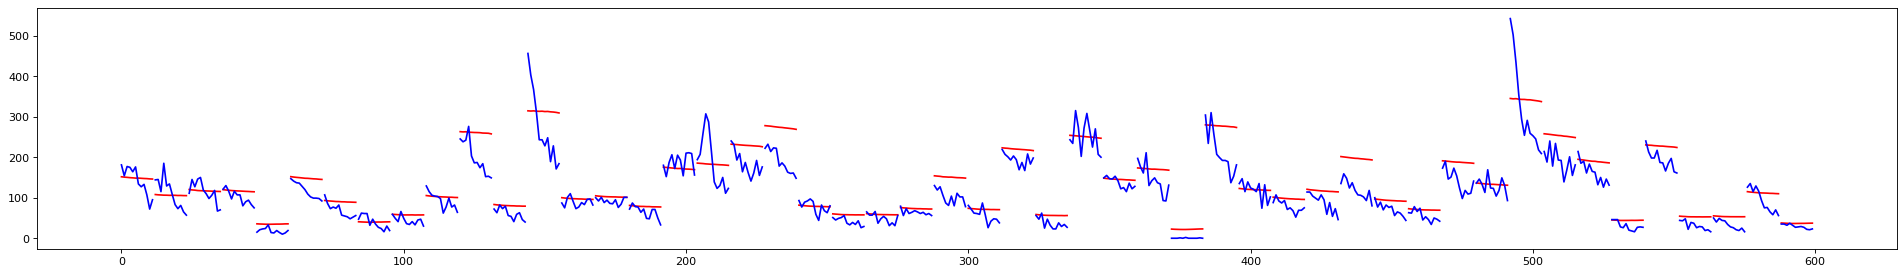

In [41]:
#visulizing data predictions using matplotlib
from matplotlib.pyplot import figure

figure(figsize=(30,4), dpi=80)
for i in range(50):
    new_i = i * 12
    plt.plot(range(0+new_i,12+new_i),sample_output[i].detach().cpu().numpy(), color = 'red')
    plt.plot(range(0+new_i,12+new_i),sample_labels[i].cpu().numpy(), color='blue')
plt.show()